# Evaluate classification accuracy

This notebook demonstrates how to evaluate classification accuracy of "cross-validated" simulated communities. Due to the unique nature of this analysis, the metrics that we use to evaluate classification accuracy are different from those used for mock.

The key measure here is rate of ``match`` vs. ``overclassification``, hence P/R/F are not useful metrics. Instead, we define and measure the following as percentages:
* Match vs. overclassification rate
    * Match: exact match at level L
    * underclassification: lineage assignment is correct, but shorter than expected (e.g., not to species level)
    * misclassification: incorrect assignment
    
Where ``L`` = taxonomic level being tested


## Functions

In [1]:
from tax_credit.framework_functions import (novel_taxa_classification_evaluation,
                                            extract_per_level_accuracy)
from tax_credit.eval_framework import (parameter_comparisons,
                                       method_by_dataset)
from tax_credit.plotting_functions import (pointplot_from_data_frame,
                                           heatmap_from_data_frame,
                                           per_level_kruskal_wallis)

import pandas as pd
from os.path import expandvars, join, exists
from glob import glob
from IPython.display import display

## Evaluate classification results
First, enter in filepaths and directory paths where your data are stored, and the destination

In [2]:
project_dir = expandvars("$HOME/Desktop/projects/short-read-tax-assignment")
analysis_name = "simulated-community"
precomputed_results_dir = join(project_dir, "data", "precomputed-results", analysis_name)
expected_results_dir = join(project_dir, "data", analysis_name)
summary_fp = join(precomputed_results_dir, 'evaluate_classification_summary.csv')

results_dirs = glob(join(precomputed_results_dir, '*', '*', '*', '*'))

This cell performs the classification evaluation and should not be modified.

In [3]:
if not exists(summary_fp):
    accuracy_results = novel_taxa_classification_evaluation(results_dirs, expected_results_dir,
                                                            summary_fp, test_type='cross-validated')
else:
    accuracy_results = pd.DataFrame.from_csv(summary_fp)

# Plot classification accuracy
Finally, we plot our results. Line plots show the mean +/- 95% confidence interval for each classification result at each taxonomic level (1 = phylum, 6 = species) in each dataset tested. Do not modify the cell below, except to adjust the color_pallette used for plotting. This palette can be a dictionary of colors for each group, as shown below, or a [seaborn color palette](http://seaborn.pydata.org/tutorial/color_palettes.html).

**match_ratio** = proportion of correct matches.

**underclassification_ratio** = proportion of assignments to correct lineage but to a lower level than expected.

**misclassification_ratio** = proportion of assignments to an incorrect lineage.

In [4]:
color_pallette = dict(rdp="seagreen", sortmerna="gray", uclust="blue", blast="black")

level_results = extract_per_level_accuracy(accuracy_results)

y_vars = ['Precision', 'Recall', 'F-measure', "match_ratio"]

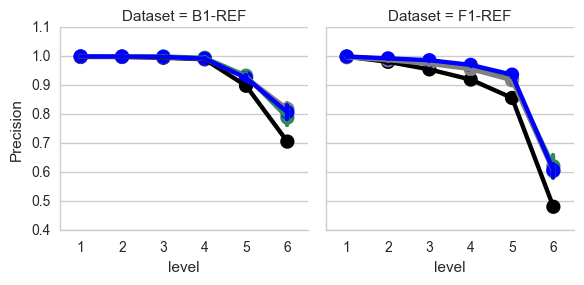

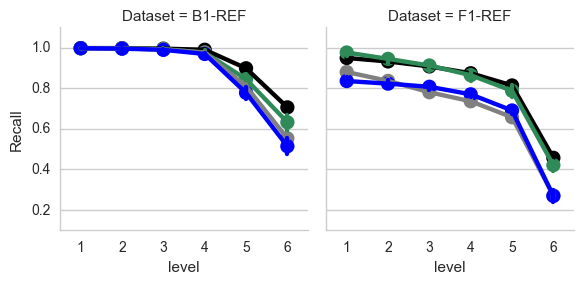

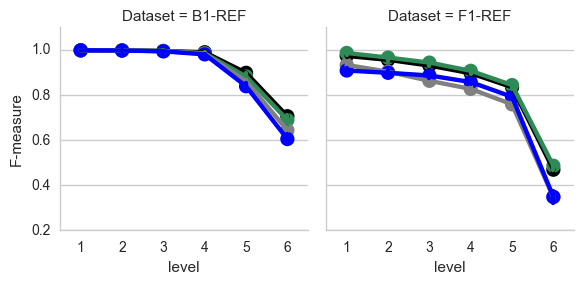

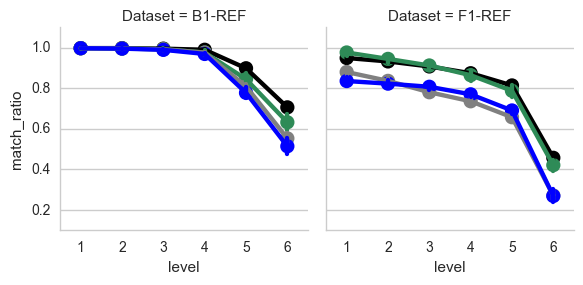

In [7]:
pointplot_from_data_frame(level_results, "level", y_vars,
                          group_by="Dataset", color_by="Method",
                          color_pallette=color_pallette)

## Per-level classification accuracy statistic
Kruskal-Wallis FDR-corrected p-values comparing classification methods at each level of taxonomic assignment

In [34]:
result = per_level_kruskal_wallis(level_results, y_vars, group_by='Method', 
                                  dataset_col='Dataset', alpha=0.05, 
                                  pval_correction='fdr_bh')
result

Dataset     Variable             1             2             3  \
0  B1-REF  match_ratio  4.931127e-01  1.001115e-01  9.393680e-05   
1  F1-REF  match_ratio  8.682024e-18  9.173759e-14  5.083769e-12   

              4             5             6  
0  3.141971e-05  3.141971e-05  3.141971e-05  
1  1.012529e-11  1.207972e-11  6.964671e-10

## Heatmap of method accuracy by parameter

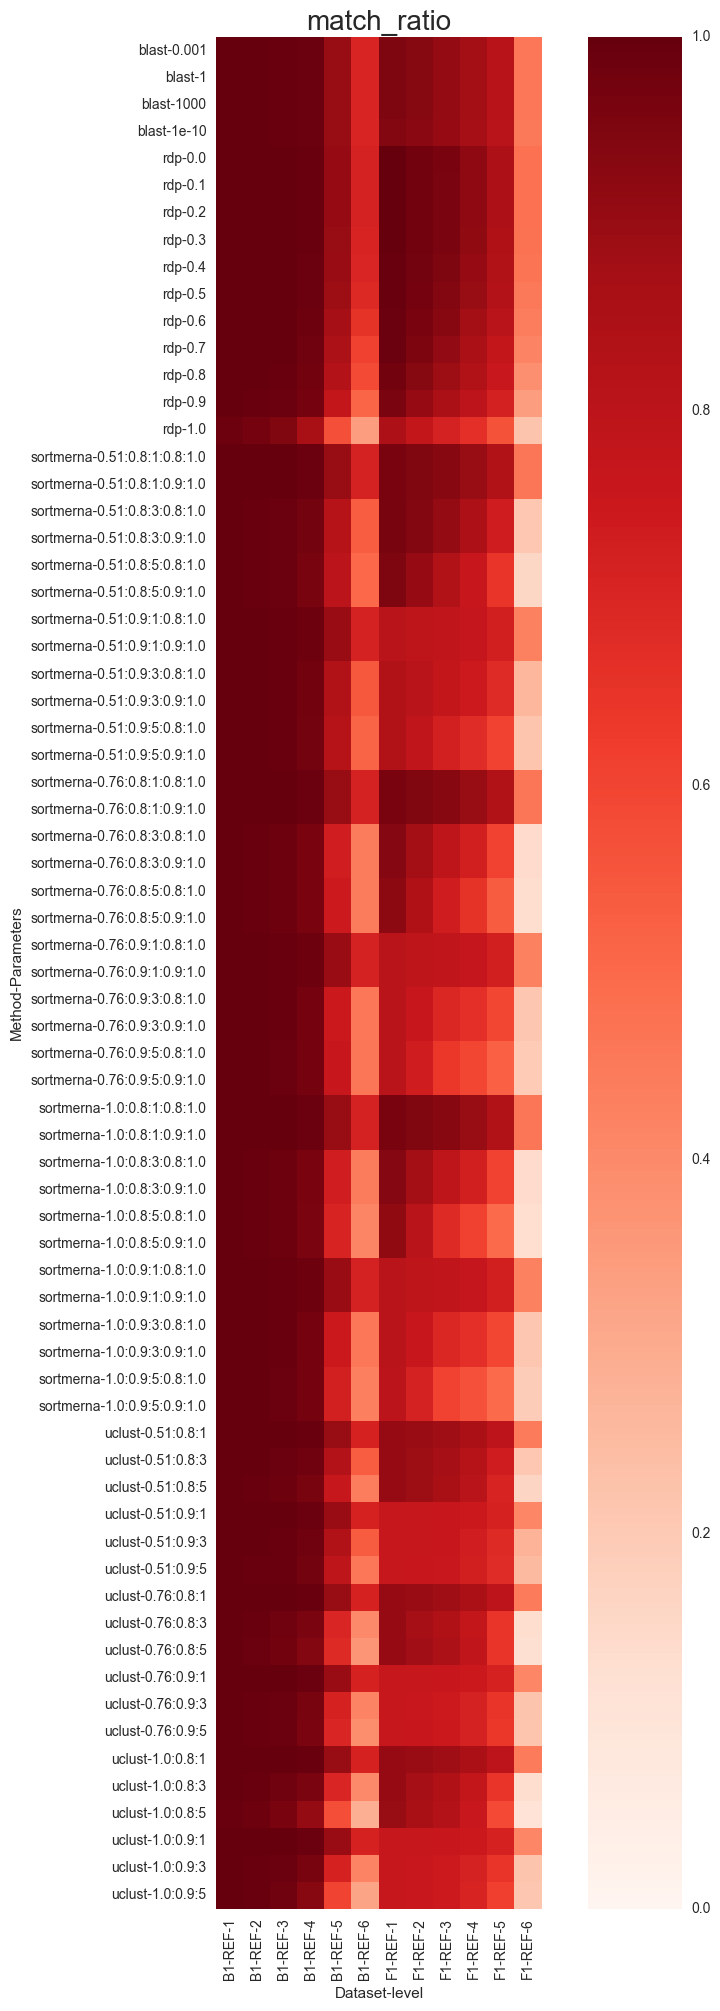

In [35]:
heatmap_from_data_frame(level_results, metric="match_ratio", rows=["Method", "Parameters"], cols=["Dataset", "level"])

## Rank-based statistics comparing the performance of the optimal parameter setting run for each method on each data set.
Rank parameters for each method to determine the best parameter configuration within each method. *Count best* column indicates how many samples a given method achieved within one mean absolute deviation of the best result (which is why they sum to more than the total number of samples).

In [36]:
for method in level_results['Method'].unique():
    top_params = parameter_comparisons(level_results, method, metrics=y_vars, 
                                       sample_col='Dataset', method_col='Method',
                                       dataset_col='Dataset')
    print(method)
    display(top_params[:10])

blast


match_ratio
0.001           24
1               24
1000            24
1e-10           24

rdp


match_ratio
0.0           28
0.1           28
0.2           28
0.3           27
0.4           27
0.5           26
0.6           25
0.7           23
0.8           22
0.9           20

sortmerna


match_ratio
0.51:0.8:1:0.8:1.0           30
1.0:0.8:1:0.9:1.0            30
1.0:0.8:1:0.8:1.0            30
0.76:0.8:1:0.8:1.0           30
0.76:0.8:1:0.9:1.0           30
0.51:0.8:1:0.9:1.0           30
0.51:0.8:3:0.8:1.0           24
0.51:0.8:3:0.9:1.0           24
0.51:0.8:5:0.8:1.0           21
0.51:0.8:5:0.9:1.0           21

uclust


match_ratio
0.51:0.8:1           30
1.0:0.8:1            30
0.76:0.8:1           30
0.51:0.8:3           25
0.51:0.8:5           24
1.0:0.8:3            24
0.76:0.8:3           24
0.76:0.8:5           24
1.0:0.9:1            22
1.0:0.8:5            22

Now we rank the top-performing method/parameter combination for each method from family to species level

In [37]:
for dataset in level_results['Dataset'].unique():
    for level in range(4,7):
        method_rank = method_by_dataset(level_results[level_results["level"] == level],
                                        dataset=dataset, sort_field='match_ratio',
                                        display_fields=("Method", "Parameters", "match_ratio"))
        print("{0} level {1}".format(dataset, level))
        display(method_rank)

B1-REF level 4


Method         Parameters  match_ratio
441        rdp                0.0     0.997409
795     uclust          1.0:0.8:1     0.997409
429      blast               1000     0.994819
243  sortmerna  1.0:0.8:1:0.9:1.0     0.994764

B1-REF level 5


Method          Parameters  match_ratio
28         rdp                 0.0     0.921466
310     uclust          0.51:0.8:1     0.910995
928  sortmerna  0.51:0.8:1:0.9:1.0     0.907821
10       blast                   1     0.900524

B1-REF level 6


Method         Parameters  match_ratio
29         rdp                0.0     0.751309
365     uclust         0.76:0.9:1     0.746073
5        blast              0.001     0.727749
239  sortmerna  1.0:0.8:1:0.8:1.0     0.727749

F1-REF level 4


Method          Parameters  match_ratio
1269        rdp                 0.0     0.938875
1335  sortmerna  0.51:0.8:1:0.8:1.0     0.933985
1251      blast                   1     0.894866
1623     uclust           1.0:0.8:1     0.880196

F1-REF level 5


Method          Parameters  match_ratio
1408  sortmerna  0.76:0.8:1:0.8:1.0     0.870416
1270        rdp                 0.0     0.867971
1252      blast                   1     0.828851
1624     uclust           1.0:0.8:1     0.823961

F1-REF level 6


Method          Parameters  match_ratio
1271        rdp                 0.0     0.501222
1415  sortmerna  0.76:0.8:1:0.9:1.0     0.488998
1253      blast                   1     0.474328
1589     uclust          0.76:0.8:1     0.469438